In [2958]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2959]:
P_0S = 341.3
r_SM = 0.1065
r_SE = 0.17
a_O3 = 0.08
a_SW = 0.1451
a_LW = 0.8258
e_E = 1
e_A = 0.875
f_A = 0.618
alpha = 3
beta = 4
sigma = 5.67e-8

## Equations without cloud coverage:

$$
(a_{SW}+a_{O3})(1-r_{SM})P_0^S+a_{LW}\sigma\varepsilon_E T_E^4 - (1+f)\sigma \varepsilon_A T_A^4 - (\alpha+\beta)(T_A-T_E)
$$
$$
(1-r_{SE})(1-(a_{O3}+a_{SW}))(1-r_{SM})P_0^S-\sigma \varepsilon_E T_E^4 + \sigma \varepsilon_A T_A^4 + (\alpha+\beta)(T_A-T_E)
$$

In [2960]:
def temperature(T):
    c_1 = (1-r_SE)*(1-(a_O3+a_SW))*(1-r_SM)*P_0S
    c_2 = (a_SW+a_O3)*(1-r_SM)*P_0S
    return [c_1 - sigma*e_E*T[0]**4+sigma*e_A*T[1]**4+(alpha+beta)*(T[1]-T[0]) - 0.6,
            c_2 + a_LW*sigma*e_E*T[0]**4 - (1+f_A)*sigma*e_A*T[1]**4 - (alpha+beta)*(T[1]-T[0])]

In [2961]:
temps = sp.optimize.fsolve(temperature, [290,290])
print(temps)

[293.23129572 280.99660418]


In [2962]:
C_c = 0.66
a_SC = 0.1239
r_SC = 0.22
r_LC = 0.195
a_LC = 0.622

In [2963]:
def temperature_c(T):
    c_1 = (1-r_SE)*(1-(a_O3+a_SW + C_c*a_SC))*(1-(r_SM+C_c*r_SC))*P_0S
    c_2 = (a_SW+a_O3 )*(1-(r_SM))*P_0S
    return [c_1 - (1-C_c*r_LC)*sigma*e_E*T[0]**4+sigma*e_A*T[1]**4+(alpha+beta)*(T[1]-T[0]) - 0.6,
            c_2 + (a_LW+C_c*a_LC)*(1-C_c*r_LC)*sigma*e_E*T[0]**4 - (1+f_A)*sigma*e_A*T[1]**4 - (alpha+beta)*(T[1]-T[0])]

In [2964]:
temps_c = sp.optimize.fsolve(temperature_c, [200,200])
print(temps_c- 273)

[70.12996372 59.95552947]


# FDM on equation (6)

In [2965]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [2985]:
D = 0.3
x_min = 0
x_max = 1
N = 1000
x = np.linspace(x_min,x_max,N)
h = x[1]-x[0]
x_s = np.sin(75*np.pi/180)
x_s = 0.9394
B = 1.45
A = 201.4
S_2 = -0.477
S = lambda v : 1 + S_2/2*(3*v**2-1)
a = np.where(x<x_s, np.where(x>x_s,x,x*0+0.68),x*0+0.38)
Q = 1360/4

In [2986]:
def temp(D = D,Q = Q):
    T_matrix = tridiag(-D*(1-x**2)/(h**2)+D*x/h,2*D*(1-x**2)/(h**2)+B,-D*(1-x**2)/(h**2)-D*x/h, N)
    T_matrix[0,0] = -1/h
    T_matrix[0,1] = 1/h
    T_matrix[-1,-1] = 1/h
    T_matrix[-1,-2] = -1/h

    f = np.array(Q*S(x)*a-A)
    f[0] = 0
    f[-1] = 0
    T = sp.linalg.solve(T_matrix,f)
    return T

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/r2/0pv51v_x0gzcblcwscyfvh500000gn/T/ipykernel_4719/1651171271.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$x = \sin \phi$")


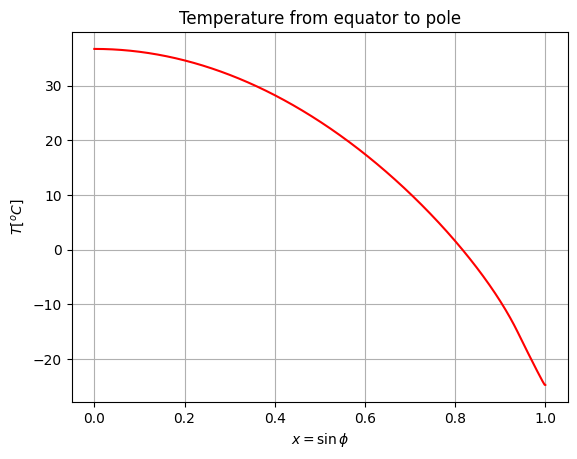

In [2994]:
T = temp()


plt.plot(x,T, color="red")
plt.grid()
plt.title("Temperature from equator to pole")
plt.xlabel("$x = \sin \phi$")
plt.ylabel("$T[^o C]$")
plt.savefig("numericaltemp.pdf",format="pdf")
plt.show()

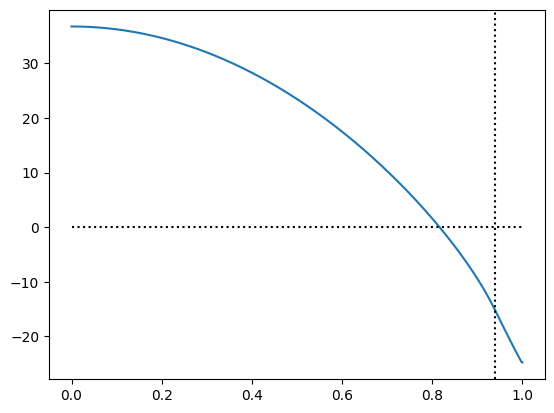

In [2995]:
T = temp()


plt.plot(x,T)
plt.plot(x,np.zeros(N), color='black', ls='dotted')
plt.axvline(x_s, color='black', ls='dotted')
plt.show()

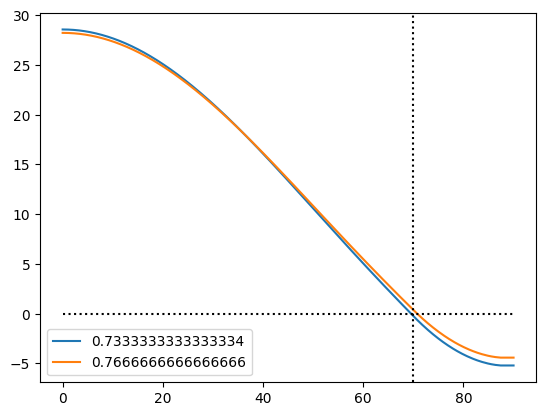

In [2989]:
for i in np.linspace(0.2,1.5,40):
    T = temp(i,Q)
    tol = 0.5
    if (-tol < T[int(x_s*N)] < tol):
        plt.plot(np.arcsin(x)/np.pi*180,T, label=f"{i}")

plt.plot(np.arcsin(x)/np.pi*180,np.zeros(N), color='black', ls='dotted')
plt.axvline(np.arcsin(x_s)/np.pi*180, color='black', ls='dotted')
plt.legend()
plt.show()

# Computing $Q(x_s)$

In [2990]:
def sum11(x,delta,it=10):
    sum = 1
    for i in range(1,it):
        prod = 1
        for j in range(i):
            prod *= ((2*i - 2*j -1)*(2*i - 2*j -2)-delta)/(2*i-j)
        sum += prod*x**(2*i)
    return sum

print(sum11(0.86,-B/D,1000))
sum11(1,-B/D, it = 1)
-B/D

inf


-4.833333333333333

In [2991]:
def sum11(x,delta,it=100):
    sum = 1
    for i in range(1,it):
        prod = 1
        for j in range(i):
            prod *= (2*j*(2*j+1)+delta)/((2*j+1)*(2*j+2))
        sum += prod*x**(2*i)
    return sum

def sum12(x,delta,it=100):
    sum = 1
    for i in range(1,it):
        prod = 1
        for j in range(i):
            prod *= (2*j*(2*j+1)+delta)/(2*(2*j+1)**2)
        sum += prod*(1-x)**(i)
    return sum

def sum21(x,delta,it=100):
    sum = 0
    for i in range(1,it):
        prod = 1
        for j in range(i):
            prod *= (2*j*(2*j+1)+delta)/((2*j+1)*(2*j+2))
        sum += prod*2*i*x**(2*i-1)
    return sum

def sum22(x,delta,it=100):
    sum = 0
    for i in range(1,it):
        prod = 1
        for j in range(i):
            prod *= (2*j*(2*j+1)+delta)/(2*(2*j+1)**2)
        sum += prod*i*(1-x)**(i-1)
    return sum

print(sum11(0.86,B/D))
print(sum12(0.86,B/D))
print(sum21(0.86,B/D))
print(sum22(0.86,B/D))

5.999796434884238
1.3689653396604213
32.711580486213045
2.8705271016549654
